# IB Strategy Debug Notebook (V4)

This notebook is used to:
1. Run single-day backtests with **PROD parameters** (baseline from V3)
2. Visualize trades with IB levels, SL/TP, and TSL changes
3. Compare results with reference data
4. Export trades for manual review

**PROD Parameters** (from AWS optimization - 129,600 combinations):
- **GER40**: IB 08:00-09:00 (Europe/Berlin), RR=1.0, TSL_TARGET=0.5, TSL_SL=1.5
- **XAUUSD**: IB 09:00-09:30 (Asia/Tokyo), RR=0.5, TSL_TARGET=0.5, TSL_SL=1.5

**V4 Research Directions**: Fractal TP targets, session volatility, BOS/CISD SL, ATR

In [ ]:
# Setup - run this first
import sys
import os
import logging
from datetime import datetime, timedelta
from pathlib import Path
import importlib

import pandas as pd
import matplotlib.pyplot as plt

# Set path to project root
NOTEBOOK_DIR = Path(os.getcwd())
DUAL_V4_PATH = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
sys.path.insert(0, str(DUAL_V4_PATH))

# Configure logging (set to WARNING to reduce noise, DEBUG for detailed logs)
logging.basicConfig(level=logging.WARNING, force=True)

# Force reload of modified modules
import notebooks.debug_tools
importlib.reload(notebooks.debug_tools)

from notebooks.debug_tools import (
    SingleDayBacktest,
    export_trades_for_debug,
    load_reference_trades,
)

# Enable inline plots (use 'inline' for static, 'widget' for interactive)
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print(f"Project path: {DUAL_V4_PATH}")
print("Setup complete! (PROD parameters loaded)")

## Configuration

Set your backtest parameters here:

In [ ]:
# ============================================================
# CONFIGURATION - Edit these values
# ============================================================

# Symbol: "GER40" or "XAUUSD"
SYMBOL = "GER40"

# Initial balance (demo: 50000, live: 100000)
INITIAL_BALANCE = 100000.0

# Risk mode - choose ONE:
# Option 1: Percentage of equity
RISK_PCT = 1.0  # 1% of equity per trade
RISK_AMOUNT = None

# Option 2: Fixed amount (uncomment to use)
# RISK_PCT = None
# RISK_AMOUNT = 1000.0  # $1000 max loss per trade

# Max margin usage
MAX_MARGIN_PCT = 40.0

# PROD Parameter Reference (auto-used by SingleDayBacktest):
# GER40:  IB 08:00-09:00 Europe/Berlin, RR=1.0, TSL=0.5/1.5, IB_BUFFER=10%, MAX_DIST=50%
# XAUUSD: IB 09:00-09:30 Asia/Tokyo, RR=0.5, TSL=0.5/1.5, IB_BUFFER=5%, MAX_DIST=125%

print(f"Symbol: {SYMBOL}")
print(f"Initial Balance: ${INITIAL_BALANCE:,.2f}")
if RISK_PCT:
    print(f"Risk: {RISK_PCT}% per trade")
else:
    print(f"Risk: ${RISK_AMOUNT:,.2f} fixed per trade")
print(f"Max Margin: {MAX_MARGIN_PCT}%")
print(f"Parameters: PROD (baseline)")

In [3]:
# Initialize backtest engine (timezone auto-detected from symbol)
backtest = SingleDayBacktest(
    symbol=SYMBOL,
    initial_balance=INITIAL_BALANCE,
    risk_pct=RISK_PCT,
    risk_amount=RISK_AMOUNT,
    max_margin_pct=MAX_MARGIN_PCT,
)

print(f"Backtest engine ready for {SYMBOL}!")
print(f"Timezone: {backtest.timezone}")

Backtest engine ready for GER40!
Timezone: Europe/Berlin


## Single Day Backtest

Run backtest for a specific date and visualize the result:

In [6]:
# ============================================================
# RUN SINGLE DAY BACKTEST
# ============================================================

# Date to test (format: YYYY-MM-DD)
TEST_DATE = "2025-05-29"

# Enable DEBUG logging for detailed TSL output (optional)
import logging
# logging.getLogger("src.strategies.ib_strategy").setLevel(logging.DEBUG)

# Re-create backtest engine to ensure clean state
backtest = SingleDayBacktest(
    symbol=SYMBOL,
    initial_balance=INITIAL_BALANCE,
    risk_pct=RISK_PCT,
    risk_amount=RISK_AMOUNT,
    max_margin_pct=MAX_MARGIN_PCT,
)

# Run backtest for the day
result = backtest.run_day(TEST_DATE)

# Show results
if result["error"]:
    print(f"Error: {result['error']}")
else:
    print(f"\n{'='*50}")
    print(f"DATE: {TEST_DATE} | SYMBOL: {SYMBOL}")
    print(f"{'='*50}")
    
    # IB Data
    if result["ib_data"]:
        ib = result["ib_data"]
        print(f"\nIB Levels:")
        print(f"  IBH: {ib['ibh']:.2f}")
        print(f"  IBL: {ib['ibl']:.2f}")
        print(f"  EQ:  {ib['eq']:.2f}")
        print(f"  IB Range: {ib['ibh'] - ib['ibl']:.2f} points")
    
    # Signals
    if result["signals"]:
        print(f"\nSignal detected:")
        sig = result["signals"][0]
        print(f"  Time: {sig['time'].strftime('%H:%M')} UTC")
        print(f"  Variation: {sig['variation']}")
        print(f"  Direction: {sig['direction'].upper()}")
        print(f"  Entry: {sig['entry_price']:.2f}")
        print(f"  SL: {sig['stop_loss']:.2f}")
        print(f"  TP: {sig['take_profit']:.2f}")
    else:
        print("\nNo signals detected")
    
    # Trade
    if result["trade"]:
        trade = result["trade"]
        print(f"\nTrade Executed:")
        print(f"  Entry: {trade.entry_price:.2f} @ {trade.entry_time.strftime('%H:%M:%S')}")
        print(f"  Volume: {trade.volume:.2f} lots")
        print(f"  SL: {trade.sl:.2f}")
        print(f"  TP: {trade.tp:.2f}")
        print(f"  Exit: {trade.exit_price:.2f} @ {trade.exit_time.strftime('%H:%M:%S')}")
        print(f"  Exit Reason: {trade.exit_reason}")
        print(f"  P/L: ${trade.profit:.2f}")
        
        # Calculate R value
        if RISK_AMOUNT:
            risk_money = RISK_AMOUNT
        else:
            risk_money = INITIAL_BALANCE * RISK_PCT / 100
        r_value = trade.profit / risk_money if risk_money > 0 else 0
        print(f"  R: {r_value:+.2f}")
    else:
        print("\nNo trade executed")


DATE: 2025-05-29 | SYMBOL: GER40

IB Levels:
  IBH: 24301.80
  IBL: 24218.30
  EQ:  24260.05
  IB Range: 83.50 points

Signal detected:
  Time: 07:40 UTC
  Variation: TCWE
  Direction: SHORT
  Entry: 24185.80
  SL: 24123.80
  TP: 24123.80

Trade Executed:
  Entry: 24185.30 @ 07:40:00
  Volume: 0.81 lots
  SL: 24123.80
  TP: 24123.80
  Exit: 24091.30 @ 10:15:00
  Exit Reason: time
  P/L: $1522.80
  R: +1.52


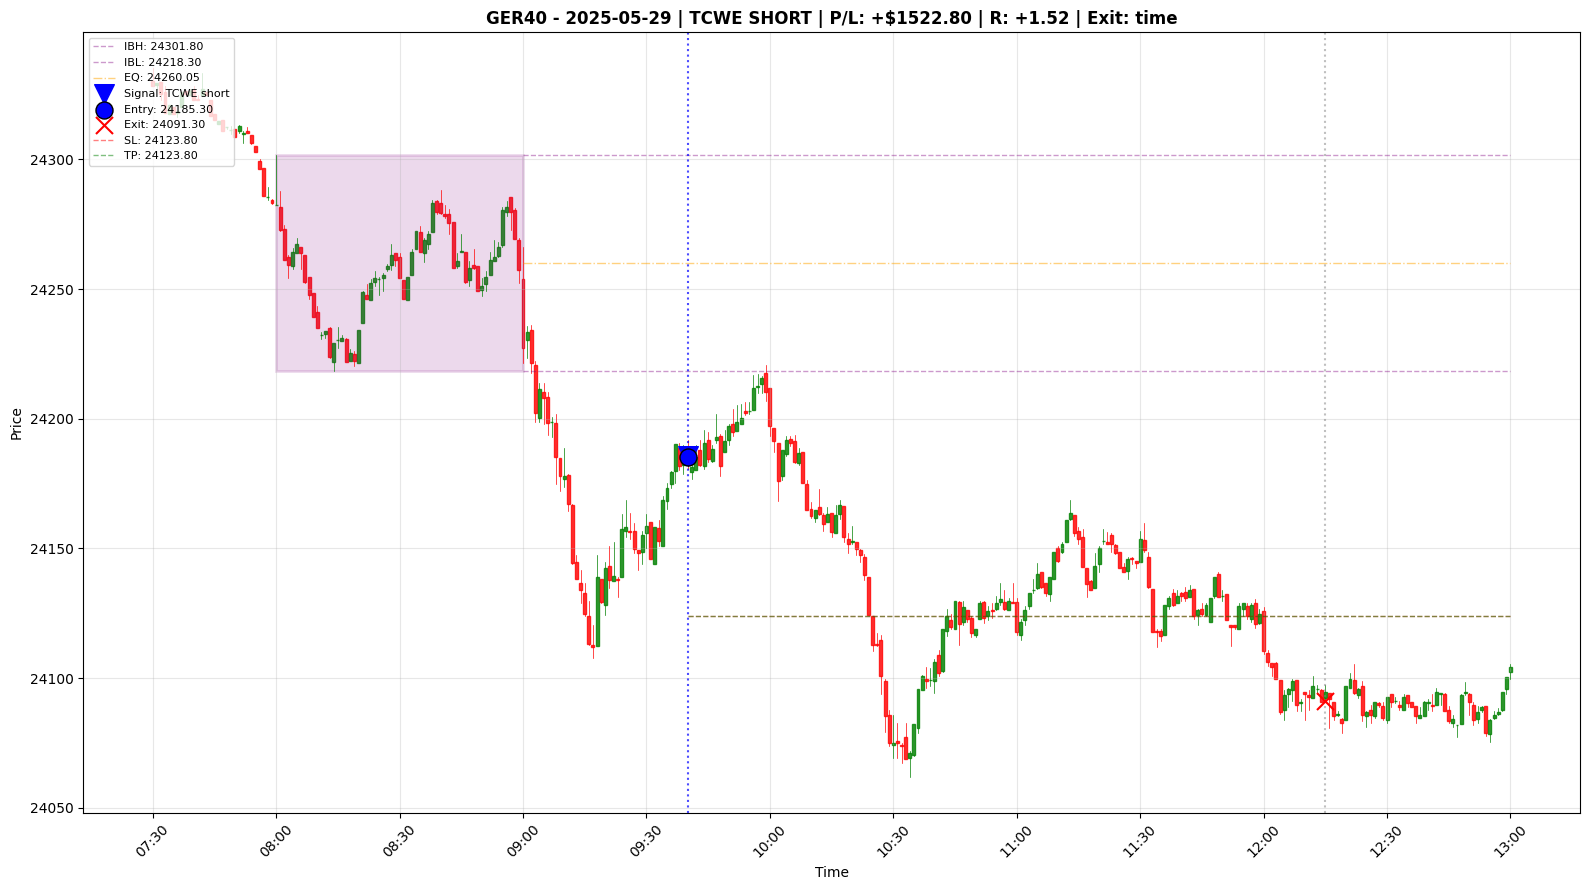

In [7]:
# ============================================================
# GENERATE CHART
# ============================================================

# Generate chart (hours_after_ib controls how much time after IB to show)
fig = backtest.generate_chart(result, figsize=(16, 9), hours_after_ib=4.0)

if fig:
    # Optional: Save chart to file
    # fig.savefig(f"debug_{SYMBOL}_{TEST_DATE}.png", dpi=150, bbox_inches='tight')
    
    plt.show()
else:
    print("No chart generated (no data or error)")

In [ ]:
# ============================================================
# SHOW TSL (Trailing Stop Loss) DETAILS
# ============================================================

if result["trade"] and result.get("tsl_state"):
    tsl = result["tsl_state"]
    print(f"\nTSL State:")
    print(f"  TSL_TARGET: {tsl.get('tsl_target')} (activate at this R)")
    print(f"  TSL_SL: {tsl.get('tsl_sl')} (lock in profit at this R)")
    print(f"  Initial Virtual TP: {tsl.get('initial_tp', 'N/A')}")
    print(f"  Current Virtual TP: {tsl.get('current_tp', 'N/A')}")
    print(f"  TSL Triggered: {tsl.get('tsl_triggered', False)}")
    
    tsl_history = tsl.get("tsl_history", [])
    if tsl_history:
        print(f"\n  TSL History ({len(tsl_history)} adjustments):")
        for i, h in enumerate(tsl_history, 1):
            print(f"    [{i}] {h['time'].strftime('%H:%M:%S')} - SL moved to {h['sl']:.2f}, TP to {h['tp']:.2f}")
    else:
        print(f"\n  TSL History: No adjustments (TP not hit)")
elif result["trade"]:
    print("\nTSL State: Not available (no virtual TP hit)")
else:
    print("\nNo trade executed")

In [ ]:
# ============================================================
# SAVE CHART TO FILE (optional)
# ============================================================

# Uncomment to save the chart
SAVE_CHART = False
CHART_OUTPUT_DIR = DUAL_V4_PATH / "notebooks" / "debug_charts"

if SAVE_CHART and result["trade"]:
    CHART_OUTPUT_DIR.mkdir(exist_ok=True)
    chart_path = CHART_OUTPUT_DIR / f"{SYMBOL}_{TEST_DATE}_{result['trade'].variation}.png"
    fig = backtest.generate_chart(result, figsize=(16, 9), hours_after_ib=4.0)
    if fig:
        fig.savefig(chart_path, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"Chart saved to: {chart_path}")
elif SAVE_CHART:
    print("No trade to save chart for")

## Batch Analysis

Run backtest for multiple dates and compare with full backtest results:

In [ ]:
# ============================================================
# RUN BATCH ANALYSIS FOR SPECIFIC DATES
# ============================================================

# List of dates to analyze (from run_backtest_v3.py results or manual selection)
DATES_TO_CHECK = [
    "2023-01-05",
    "2023-01-06",
    "2023-01-09",
    "2023-01-10",
]

results_batch = []

for date in DATES_TO_CHECK:
    result = backtest.run_day(date)
    
    if result["trade"]:
        trade = result["trade"]
        if RISK_AMOUNT:
            risk_money = RISK_AMOUNT
        else:
            risk_money = INITIAL_BALANCE * RISK_PCT / 100
        r_value = trade.profit / risk_money if risk_money > 0 else 0
        
        results_batch.append({
            "Date": date,
            "Variation": trade.variation,
            "Direction": trade.direction.upper(),
            "Entry": trade.entry_price,
            "SL": trade.sl,
            "TP": trade.tp,
            "Exit": trade.exit_price,
            "Exit Reason": trade.exit_reason,
            "P/L": round(trade.profit, 2),
            "R": round(r_value, 2),
        })
    else:
        results_batch.append({
            "Date": date,
            "Variation": "-",
            "Direction": "-",
            "Entry": "-",
            "SL": "-",
            "TP": "-",
            "Exit": "-",
            "Exit Reason": result.get("error", "No signal"),
            "P/L": 0,
            "R": 0,
        })

# Display results
results_df = pd.DataFrame(results_batch)
print(f"\nBatch Results for {SYMBOL}:")
print(f"Trades: {len([r for r in results_batch if r['Variation'] != '-'])}")
print(f"Total P/L: ${sum([r['P/L'] for r in results_batch if isinstance(r['P/L'], (int, float))]):.2f}")
print(f"Total R: {sum([r['R'] for r in results_batch if isinstance(r['R'], (int, float))]):.2f}")
print()
display(results_df)

In [ ]:
# ============================================================
# COMPARE WITH REFERENCE DATA (optional)
# ============================================================

# Load reference data if available (from dual_v3 project_info - moved to _trash)
REFERENCE_PATH = DUAL_V4_PATH / "project_info" / "DUAL_ASSET_R272.0_GER147.0_XAU125.0.xlsx"

if REFERENCE_PATH.exists():
    ref_df = load_reference_trades(str(REFERENCE_PATH), symbol=SYMBOL)
    print(f"Loaded {len(ref_df)} reference trades for {SYMBOL}")
    
    # Get reference trade for the test date
    ref_trade = ref_df[ref_df["Date"] == pd.to_datetime(TEST_DATE)]
    
    if not ref_trade.empty:
        print(f"\n=== Reference Trade for {TEST_DATE} ===")
        row = ref_trade.iloc[0]
        print(f"Variation: {row['Variation']}")
        print(f"Direction: {row['Direction']}")
        print(f"IB_H: {row['IB_H']:.2f}, IB_L: {row['IB_L']:.2f}, EQ: {row['EQ']:.2f}")
        print(f"Entry: {row['Entry_Price']:.2f} @ {row['Entry_Time']}")
        print(f"SL: {row['SL']:.2f}, TP: {row['TP']:.2f}")
        print(f"Exit: {row['Exit_Price']:.2f} @ {row['Exit_Time']}")
        print(f"Exit Reason: {row['Exit_Reason']}")
        print(f"R: {row['R']:.2f}")
    else:
        print(f"No reference trade found for {TEST_DATE}")
else:
    print(f"Reference file not found: {REFERENCE_PATH}")
    print("Skipping comparison with reference data")

## Quick Date Range Test

Run backtest for multiple dates:

In [ ]:
# Run backtest for a range of dates
START_DATE = datetime(2023, 1, 2)
END_DATE = datetime(2023, 1, 31)

results = []
current_date = START_DATE

while current_date <= END_DATE:
    # Skip weekends
    if current_date.weekday() < 5:
        result = backtest.run_day(current_date)
        if result["trade"]:
            trade = result["trade"]
            risk = abs(trade.entry_price - trade.sl) if trade.sl else 0
            r_value = trade.profit / risk if risk > 0 else 0
            
            results.append({
                "Date": current_date.strftime("%Y-%m-%d"),
                "Variation": trade.variation,
                "Direction": trade.direction.upper(),
                "Entry": trade.entry_price,
                "Exit": trade.exit_price,
                "Exit Reason": trade.exit_reason,
                "P/L": trade.profit,
                "R": round(r_value, 2),
            })
    
    current_date += timedelta(days=1)

# Display results
results_df = pd.DataFrame(results)
print(f"\nTrades found: {len(results_df)}")
print(f"Total P/L: ${results_df['P/L'].sum():.2f}")
print(f"Win Rate: {(results_df['P/L'] > 0).mean() * 100:.1f}%")
print("\n")
display(results_df)

## Export for Debug Review

Export trades to Excel with Status and Comment columns for manual review:

In [ ]:
# ============================================================
# EXPORT TRADES FOR MANUAL REVIEW
# ============================================================
# This section allows exporting trades from a date range to Excel
# with columns for Status and Comments for manual review

from backtest.config import BacktestConfig, SymbolConfig

# Symbol configuration (matches run_backtest_v3.py)
if SYMBOL == "GER40":
    symbol_config = SymbolConfig(
        name="GER40",
        trade_contract_size=1.0,
        trade_tick_value=0.5,  # EUR per tick for DAX index
        trade_tick_size=0.5,
        volume_min=0.01,
        volume_max=100.0,
        volume_step=0.01,
        spread_points=1.5,
        digits=2,
    )
else:  # XAUUSD
    symbol_config = SymbolConfig(
        name="XAUUSD",
        trade_contract_size=100.0,
        trade_tick_value=1.0,
        trade_tick_size=0.01,
        volume_min=0.01,
        volume_max=100.0,
        volume_step=0.01,
        spread_points=0.30,
        digits=2,
    )

config = BacktestConfig(
    initial_balance=INITIAL_BALANCE,
    leverage=100,
    symbols={SYMBOL: symbol_config},  # Must be a dict
)

print(f"Config created for {SYMBOL}")
print("Run the next cell to execute backtest and export.")

In [ ]:
# Run full backtest for export
# WARNING: This may take a few minutes for long date ranges

EXPORT_START = datetime(2023, 1, 1)
EXPORT_END = datetime(2023, 3, 31)  # 3 months

print(f"Running backtest from {EXPORT_START.strftime('%Y-%m-%d')} to {EXPORT_END.strftime('%Y-%m-%d')}...")

# Collect all trades
all_trades = []
ib_data_by_date = {}

current = EXPORT_START
while current <= EXPORT_END:
    if current.weekday() < 5:  # Skip weekends
        result = backtest.run_day(current)
        if result["trade"]:
            all_trades.append(result["trade"])
        if result["ib_data"]:
            ib_data_by_date[current.strftime("%Y-%m-%d")] = result["ib_data"]
    current += timedelta(days=1)
    
    # Progress indicator
    if current.day == 1:
        print(f"  Processing {current.strftime('%Y-%m')}...")

print(f"\nFound {len(all_trades)} trades")

In [ ]:
# Export to Excel
OUTPUT_PATH = str(DUAL_V4_PATH / "notebooks" / f"debug_trades_{SYMBOL}.xlsx")

export_trades_for_debug(
    trade_log=all_trades,
    output_path=OUTPUT_PATH,
    ib_data_by_date=ib_data_by_date,
)

print(f"\nFile saved to: {OUTPUT_PATH}")
print("\nColumns for review:")
print("  - Status: Mark as OK, ISSUE, or SKIP")
print("  - Comment: Add notes about what's wrong")

## Debug Specific Issue

Use this section to investigate specific problems:

In [ ]:
# Enable detailed logging for debugging
logging.getLogger("src.strategies.ib_strategy").setLevel(logging.DEBUG)
logging.getLogger("backtest").setLevel(logging.DEBUG)

# Run single day with detailed logs
DEBUG_DATE = "2023-01-05"  # Change to problematic date

print(f"Running {DEBUG_DATE} with DEBUG logging...\n")
result = backtest.run_day(DEBUG_DATE)

# Reset logging level
logging.getLogger("src.strategies.ib_strategy").setLevel(logging.WARNING)
logging.getLogger("backtest").setLevel(logging.WARNING)

In [ ]:
# ============================================================
# VIEW RAW CANDLE DATA (for debugging)
# ============================================================

if not result["candles"].empty:
    import pytz
    candles = result["candles"].copy()
    tz = pytz.timezone(backtest.timezone)
    
    # Convert time to local timezone
    candles["time_local"] = candles["time"].dt.tz_convert(tz)
    candles["hour"] = candles["time_local"].dt.hour
    candles["minute"] = candles["time_local"].dt.minute
    
    # Filter to IB period (based on strategy params)
    ib_start_hour = int(backtest.strategy.ib_start.split(":")[0])
    ib_end_hour = int(backtest.strategy.ib_end.split(":")[0])
    ib_end_min = int(backtest.strategy.ib_end.split(":")[1])
    
    ib_candles = candles[
        (candles["hour"] >= ib_start_hour) & 
        ((candles["hour"] < ib_end_hour) | 
         ((candles["hour"] == ib_end_hour) & (candles["minute"] < ib_end_min)))
    ]
    
    print(f"IB Period Candles ({backtest.strategy.ib_start} - {backtest.strategy.ib_end} {backtest.timezone}):")
    display(ib_candles[["time_local", "open", "high", "low", "close"]])
else:
    print("No candle data available")